In [1]:
%pylab inline
import math
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import fisher_exact, pearsonr
import scipy

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_path = "/storage/pandaman/project/Alzheimers_ResNet/storage/gnomAD/simplified_gnomad.txt"
TF_names = ["PU1", "LHX2", "NeuN", "Olig2"]

# singleton

In [3]:
def acquire_thresholds(percentile):
    thresholds = [0 for TF_idx in range(4)]
    for TF_idx in range(4):    
        score_list = []
        for line in open(data_path):
            elems = line.strip().split()
            TF_score = float(elems[7+TF_idx])
            if TF_score != -1:
                score_list.append(abs(TF_score))
        score_list.sort()
        thres_idx = int(len(score_list) * percentile)
        thresholds[TF_idx] = score_list[thres_idx]
    print("Threshold: ", thresholds)
    return thresholds

In [4]:
def compute_singleton_rate(thresholds, skip_pval):
    p_sing_list = []
    se_sing_list = []
    
    n_snps_ttl = 0
    n_singletons_ttl = 0
    n_snps_hs_ttl = 0
    n_singletons_hs_ttl = 0
    
    for TF_idx in [0, 1, 3, 2]:
        n_snps = 0
        n_singletons = 0
        n_snps_hs = 0
        n_singletons_hs = 0
        for line in open(data_path):
            elems = line.strip().split()
            AC = int(elems[5])
            AN = int(elems[6])
            TF_score = float(elems[7+TF_idx])
            if TF_score != -1:
                n_snps_ttl += 1
                n_snps += 1
                if AC == 1 or (AN-AC) == 1:
                    n_singletons_ttl += 1
                    n_singletons += 1
                if abs(TF_score) > thresholds[TF_idx]:
                    n_snps_hs += 1
                    n_snps_hs_ttl += 1
                    if AC == 1 or (AN-AC) == 1:
                        n_singletons_hs += 1
                        n_singletons_hs_ttl += 1
        
        p_sing = float(n_singletons_hs)/n_snps_hs
        p_sing_list.append(p_sing)
        se_sing = np.sqrt(p_sing*(1-p_sing)/float(n_snps_hs))
        se_sing_list.append(se_sing)
        
        if not skip_pval:
            p_sing_ttl = float(n_singletons)/n_snps
            p_sing_others = (n_singletons-n_singletons_hs)*1.0/(n_snps-n_snps_hs)
            #se_pval = np.sqrt(p_sing_ttl*(1-p_sing_ttl)*(1.0/n_snps_hs+1.0/(n_snps-n_snps_hs)))
            se_pval = np.sqrt(p_sing*(1-p_sing)/n_snps_hs + p_sing_others*(1-p_sing_others)/(n_snps-n_snps_hs))
            pval = scipy.stats.norm.sf((p_sing-p_sing_others)/se_pval)
        else:
            pval = "NaN"
        
        print(TF_names[TF_idx])
        print(n_snps, n_singletons, p_sing, pval)
        
        
    if not skip_pval:
        p_sing_ttl = float(n_singletons_ttl)/n_snps_ttl
        p_sing_hs = float(n_singletons_hs_ttl)/n_snps_hs_ttl
        p_sing_others = (n_singletons_ttl-n_singletons_hs_ttl)*1.0/(n_snps_ttl-n_snps_hs_ttl)
        se_pval = np.sqrt(p_sing_hs*(1-p_sing_hs)/n_snps_hs_ttl + p_sing_others*(1-p_sing_others)/(n_snps_ttl-n_snps_hs_ttl))
        #se_pval = np.sqrt(p_sing_ttl*(1-p_sing_ttl)*(1.0/n_snps_hs_ttl+1.0/(n_snps_ttl-n_snps_hs_ttl)))
        print(p_sing_hs, p_sing_others,se_pval,(p_sing_hs-p_sing_others)/se_pval,scipy.stats.norm.cdf((p_sing_hs-p_sing_others)/se_pval))
        pval = scipy.stats.norm.sf((p_sing_hs-p_sing_others)/se_pval)
        print("pvalue: %s" %(pval))
        
        
    return p_sing_list, se_sing_list

In [5]:
p_sing_mat = []
se_sing_mat = []
def record_singleton_rate(thresholds, p_sing_mat, se_sing_mat, skip_pval=False):
    p_sing_list, se_sing_list = compute_singleton_rate(thresholds, skip_pval)
    p_sing_mat.append(p_sing_list)
    se_sing_mat.append(se_sing_list)

In [6]:
record_singleton_rate([0, 0, 0, 0], p_sing_mat, se_sing_mat, skip_pval=True)

PU1
810167 403074 0.4975196471838522 NaN
LHX2
601117 303038 0.5041248209583159 NaN
Olig2
613996 309533 0.5041286913921263 NaN
NeuN
447067 226466 0.5065594195053538 NaN


In [7]:
record_singleton_rate(acquire_thresholds(0.95), p_sing_mat, se_sing_mat)

Threshold:  [0.005847797389047765, 0.0060106733723442685, 0.0060240813532479315, 0.006052970744357655]
PU1
810167 403074 0.5073318850597412 2.530802707411984e-05
LHX2
601117 303038 0.5216769256363334 2.0590921478984418e-10
Olig2
613996 309533 0.5222645688784651 3.3668552856092626e-11
NeuN
447067 226466 0.5221223102044469 8.810966479176483e-07
0.5172026048618695 0.5016225776291208 0.0014582364733119308 10.68415686885377 1.0
pvalue: 6.037057581314698e-27


In [8]:
record_singleton_rate(acquire_thresholds(0.995), p_sing_mat, se_sing_mat)

Threshold:  [0.01940369589053927, 0.01911963964114681, 0.01836362691706821, 0.019873827936364222]
PU1
810167 403074 0.5118518518518519 0.0336788312095359
LHX2
601117 303038 0.5261231281198003 0.007735900526630651
Olig2
613996 309533 0.5294884327142392 0.0023883262233764728
NeuN
447067 226466 0.5391498881431768 0.0009719286904448675
0.5246379156889716 0.502289848568367 0.0045034078206734615 4.962479084841691 0.999999652004684
pvalue: 3.4799531596078803e-07


In [9]:
print(p_sing_mat)
print(np.array(p_sing_mat)[:,3])

[[0.4975196471838522, 0.5041248209583159, 0.5041286913921263, 0.5065594195053538], [0.5073318850597412, 0.5216769256363334, 0.5222645688784651, 0.5221223102044469], [0.5118518518518519, 0.5261231281198003, 0.5294884327142392, 0.5391498881431768]]
[0.50655942 0.52212231 0.53914989]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


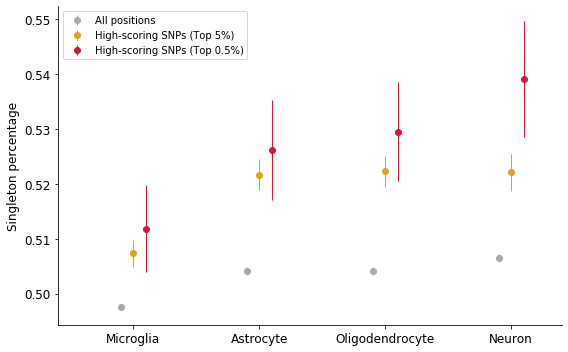

In [10]:
xvals = np.array(range(4))

w = 0.1
fig = plt.figure()
fig.set_size_inches((8, 5))
ax = fig.add_subplot(111)

colors = ["darkgray", "goldenrod", "crimson"]
labels = ["All positions", "High-scoring SNPs (Top 5%)", "High-scoring SNPs (Top 0.5%)"]
for i in range(3):
    ax.errorbar(xvals+w*i, p_sing_mat[i], label=labels[i], yerr=se_sing_mat[i], marker="o", linewidth=0, elinewidth=1, color=colors[i])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#TF_names = ["PU1", "LHX2", "NeuN", "Olig2"]
TF_full_names = ["Microglia", "Astrocyte", "Oligodendrocyte", "Neuron"]
ax.set_xticks(xvals+w)
ax.set_xticklabels(TF_full_names, size=12, fontname="Arial");
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12, fontname="Arial")
ax.legend(loc="upper left")
ax.set_ylabel("Singleton percentage", size=12, fontname="Arial")
ax.set_xlim(-0.5, 3.5)
plt.tight_layout()
# fig.savefig("./singleton_950_995.pdf")

# AgentBind score vs. MAF

In [11]:
def compute_mean_score_with_MAF(min_AF, max_AF):
    avg_score_list = []
    se_list = []
    for TF_idx in range(4):
        score_list = []
        
        for line in open(data_path):
            elems = line.strip().split()
            AC = int(elems[5])
            AN = int(elems[6])
            
            if AC == 0 or AC == AN:
                continue
            
            AF = float(AC) / AN
            MAF = AF if AF <= 0.5 else 1-AF
            TF_score = float(elems[7+TF_idx])
            
            if TF_score != -1 and MAF > min_AF and MAF <= max_AF:
                score_list.append(abs(TF_score))
        
        avg_score_list.append(np.mean(score_list))
        se_list.append(scipy.stats.sem(score_list))
        print(TF_names[TF_idx])
        print(np.mean(score_list), len(score_list))
    return avg_score_list, se_list

In [12]:
avg_score_mat = []
se_mat = []
def record_mean_score_with_MAF(min_AF, max_AF, avg_score_mat, se_mat):
    avg_score_list, se_list = compute_mean_score_with_MAF(min_AF, max_AF)
    avg_score_mat.append(avg_score_list)
    se_mat.append(se_list)

In [13]:
record_mean_score_with_MAF(min_AF=0, max_AF=1e-4, avg_score_mat=avg_score_mat, se_mat=se_mat)

PU1
0.0015106762215965235 394380
LHX2
0.0015313065452904708 297057
NeuN
0.0015716459461503592 223118
Olig2
0.001573448873611377 303342


In [14]:
record_mean_score_with_MAF(min_AF=1e-4, max_AF=1e-3, avg_score_mat=avg_score_mat, se_mat=se_mat)

PU1
0.0014643117118183428 223945
LHX2
0.001483100123258848 166409
NeuN
0.0015493100604874774 122286
Olig2
0.0015291206018465404 169540


In [15]:
record_mean_score_with_MAF(min_AF=1e-3, max_AF=1e-2, avg_score_mat=avg_score_mat, se_mat=se_mat)

PU1
0.001451461993088121 105924
LHX2
0.0014483508419746661 77427
NeuN
0.0014893165948899629 57455
Olig2
0.0014883472398744655 79622


In [16]:
record_mean_score_with_MAF(min_AF=1e-2, max_AF=1, avg_score_mat=avg_score_mat, se_mat=se_mat)

PU1
0.0014511577778295213 85755
LHX2
0.0014030619598423652 60119
NeuN
0.001393845058106344 44105
Olig2
0.0014306615034619388 61361


In [17]:
print(avg_score_mat)
print(np.array(avg_score_mat)[:,1])
print(se_mat)

[[0.0015106762215965235, 0.0015313065452904708, 0.0015716459461503592, 0.001573448873611377], [0.0014643117118183428, 0.001483100123258848, 0.0015493100604874774, 0.0015291206018465404], [0.001451461993088121, 0.0014483508419746661, 0.0014893165948899629, 0.0014883472398744655], [0.0014511577778295213, 0.0014030619598423652, 0.001393845058106344, 0.0014306615034619388]]
[0.00153131 0.0014831  0.00144835 0.00140306]
[[4.818178711935049e-06, 5.479321410847672e-06, 6.1204157470972906e-06, 5.615450689580598e-06], [6.224193687541511e-06, 7.102810910144657e-06, 8.130024736248182e-06, 7.367928761017521e-06], [9.152525398887216e-06, 1.0102763925630134e-05, 1.1454982180561477e-05, 1.0421757704083354e-05], [1.0060931507767289e-05, 1.1305016936108462e-05, 1.2402893176376099e-05, 1.1474831844374503e-05]]


In [18]:
def draw_mean_scores(xvals, avg_score_list, se_list, fig_name, real_name, color):
    ax.errorbar(xvals, avg_score_list, yerr=se_list, marker="o", linewidth=1, elinewidth=1, color=color, label=real_name)#, color="lightcoral")
    print(pearsonr(xvals, avg_score_list))

Microgolia
[0.00151068 0.00146431 0.00145146 0.00145116]
[4.81817871e-06 6.22419369e-06 9.15252540e-06 1.00609315e-05]
(-0.8765364420809627, 0.12346355791903729)
Astrocytes
[0.00153131 0.0014831  0.00144835 0.00140306]
[5.47932141e-06 7.10281091e-06 1.01027639e-05 1.13050169e-05]
(-0.9982474496890771, 0.001752550310922918)
Oligodendracytes
[0.00157345 0.00152912 0.00148835 0.00143066]
[5.61545069e-06 7.36792876e-06 1.04217577e-05 1.14748318e-05]
(-0.9970348444410465, 0.0029651555589534917)
Neurons
[0.00157165 0.00154931 0.00148932 0.00139385]
[6.12041575e-06 8.13002474e-06 1.14549822e-05 1.24028932e-05]
(-0.964052847340919, 0.035947152659080994)


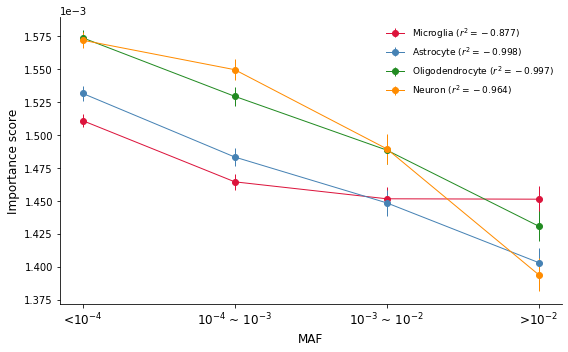

In [19]:
TF_full_names = ["Microgolia", "Astrocytes", "Neurons", "Oligodendracytes"]
real_names = ["Microglia ("+"$r^{2}=-0.877$"+")", "Astrocyte ("+"$r^{2}=-0.998$"+")",
              "Neuron ("+"$r^{2}=-0.964$"+")", "Oligodendrocyte ("+"$r^{2}=-0.997$"+")"]
colors = ["crimson", "steelblue", "darkorange", "forestgreen"]
fig = plt.figure()
fig.set_size_inches((8, 5))
ax = fig.add_subplot(111)
xvals = np.array(range(4))
for i in [0, 1, 3, 2]:
    print(TF_full_names[i])
    print(np.array(avg_score_mat)[:,i])
    print(np.array(se_mat)[:,i])
    draw_mean_scores(xvals, np.array(avg_score_mat)[:,i], np.array(se_mat)[:,i],
                     TF_full_names[i], real_names[i], colors[i])
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks(xvals)
x_labels = ["<$10^{-4}$", "$10^{-4}$ ~ $10^{-3}$", "$10^{-3}$ ~ $10^{-2}$", ">$10^{-2}$"]
ax.set_xticklabels(x_labels, size=12, fontname="Arial")
ax.set_xlabel("MAF", size=12, fontname="Arial")
ax.ticklabel_format(style='scientific', axis="y", scilimits=(0, 0))
ax.set_ylabel("Importance score", size=12, fontname="Arial")
ax.legend(fontsize=9, markerscale=1, edgecolor="white", loc=1)
plt.tight_layout()
# fig.savefig("score_vs_MAF.pdf")